In [ ]:
#Import required libraries and load the dataset:
import torch
import torchvision
import torchvision.transforms as transforms

# Define data transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 46103969.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
#Split the dataset into training, validation, and test sets:
from torch.utils.data import random_split

trainset, valset = random_split(trainset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=100, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.reshape(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validate the model
    val_loss = 0.0
    for i, data in enumerate(valloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

    # Update the learning rate using the scheduler
    scheduler.step(val_loss)


In [ ]:
#Evaluate the model's performance on the test set to ensure it demonstrates state-of-the-art performance.
correct = 0
total = 0
net.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy}%')


Accuracy of the model on the test set: 83.84%


In [ ]:
from google.colab import files, drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify a path to save to
PATH = "drive/MyDrive/UChicago/Third-Year/Spring/model_final.pt"

In [ ]:
# Save
#torch.save(net.state_dict(), PATH)

In [ ]:
# Load
device = torch.device('cpu')  # specify CPU
model = Net()
model.load_state_dict(torch.load(PATH))
model.to(device)  # move model to the specified device

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.2 MB/s eta 0:00:00


In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=bfc72d4507c1236190ce4a138f804ce02967eaf92c07b5221e7aba33801170d4
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


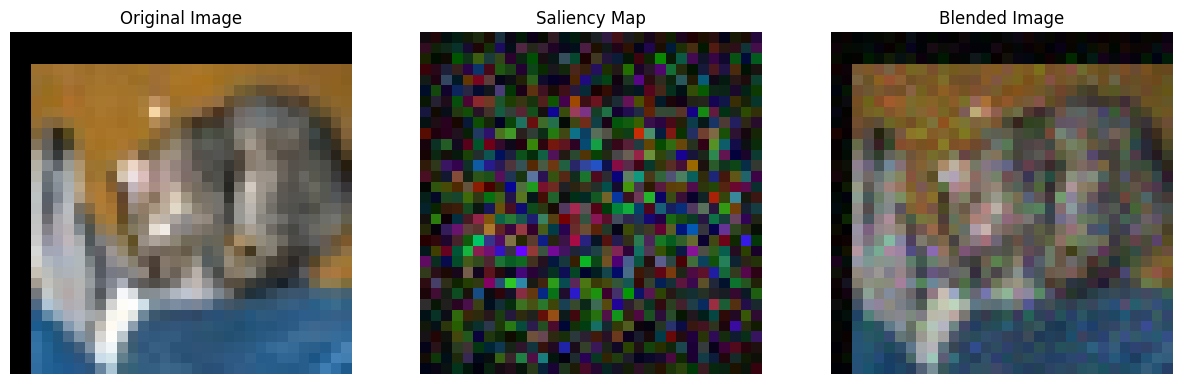

In [ ]:
#Saliency Maps 
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import Saliency

# Get a single image from the test set
image, label = testset[0]
image = image.unsqueeze(0).to(device)

# Compute saliency map
saliency = Saliency(net)
grads = saliency.attribute(image, target=label)
grads = np.squeeze(grads.cpu().detach().numpy())
grads = np.transpose(grads, (1, 2, 0))


# Visualize the saliency map
original_image = np.transpose((image.cpu().detach().numpy() * 0.5 + 0.5).squeeze(), (1, 2, 0))

# Normalize the gradient map for visualization
grads_norm = (grads - grads.min()) / (grads.max() - grads.min())

# Blend the original image and the saliency map
blended_image = 0.7 * original_image + 0.3 * grads_norm

# Plot the original image, saliency map, and blended image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[1].imshow(grads_norm)
axes[1].set_title("Saliency Map")
axes[2].imshow(blended_image)
axes[2].set_title("Blended Image")

for ax in axes:
    ax.axis("off")

plt.show()

Files already downloaded and verified


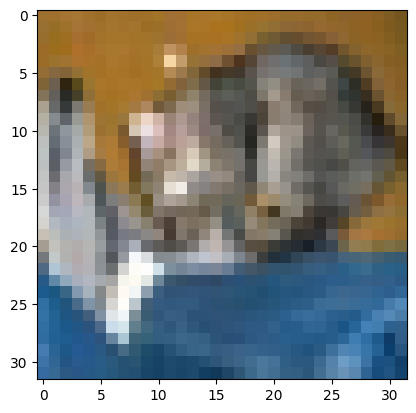

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Transform to be applied to the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the CIFAR-10 test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=0)


# Function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

image, label = testset[0]
imshow(image)

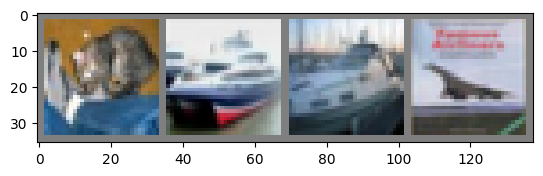

In [ ]:
# Get some random test images
# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)  # use next() function here

# Show images
imshow(torchvision.utils.make_grid(images))

  0%|          | 0/1000 [00:00<?, ?it/s]

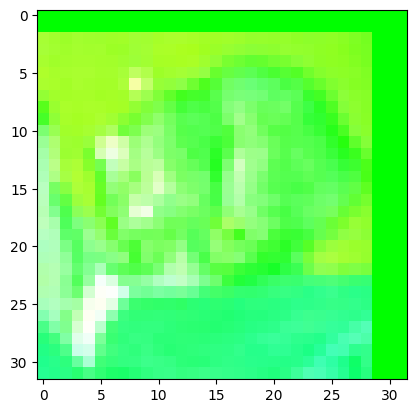

In [ ]:
#LIME Using Lime Library
import torch
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Define a prediction function for the model
def predict_fn(images):
    net.eval()
    with torch.no_grad():
        images = torch.tensor(images, device=device).permute(0, 3, 1, 2)
        outputs = net(images)
    return outputs.cpu().detach().numpy()

# Get a single image from the test set
image, label = testset[0]
image_np = (image.numpy() * 0.5 + 0.5).transpose(1, 2, 0)

# Instantiate LIME explainer
lime_explainer = lime_image.LimeImageExplainer()

# Compute LIME explanation
lime_explanation = lime_explainer.explain_instance(image_np, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

# Visualize LIME explanation
temp, mask = lime_explanation.get_image_and_mask(label, positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.show()

In [ ]:
#Focus on Attributions 

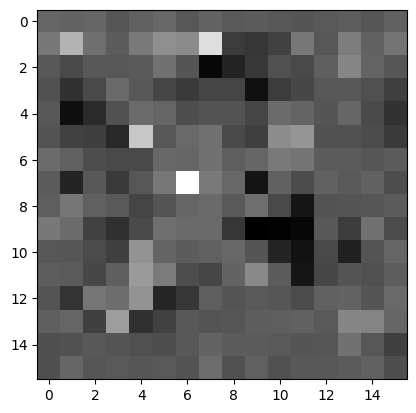

In [ ]:
import torch
import torchvision.models as models
from captum.attr import LayerIntegratedGradients
import matplotlib.pyplot as plt

# Load the pre-trained ResNet model
pretrained_model = models.resnet18(pretrained=True)
pretrained_model.eval()  # Set the model to evaluation mode

# Define the input image
image, label = testset[0]
image = image.unsqueeze(0)

# Define the layer integrated gradients object
lig = LayerIntegratedGradients(pretrained_model, pretrained_model.conv1)

# Compute the integrated gradients attribution
lig_attributions, delta = lig.attribute(image, target=0, return_convergence_delta=True)

# Get the relevance scores for the input image pixels
cond_attributions_np = lig_attributions.squeeze().detach().numpy()

# Normalize and average attributions across channels
cond_attributions_np = (cond_attributions_np - cond_attributions_np.min()) / (cond_attributions_np.max() - cond_attributions_np.min())
lig_cond_attributions_np = cond_attributions_np.mean(axis=0)

# Visualize the LRP explanation
plt.imshow(lig_cond_attributions_np, cmap="gray")
plt.show()

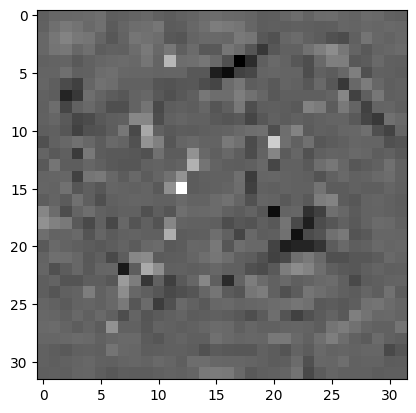

In [ ]:
import torch
import torchvision.models as models
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

# Load the pre-trained ResNet model
pretrained_model = models.resnet18(pretrained=True)
pretrained_model.eval()

# Define the input image
#image = torch.randn(1, 3, 224, 224)

# Define the Integrated Gradients object
ig = IntegratedGradients(pretrained_model)

# Compute the integrated gradients attribution
ig_attributions, delta = ig.attribute(image, target=0, return_convergence_delta=True)

# Get the relevance scores for the input image pixels
cond_attributions_np = ig_attributions.squeeze().detach().numpy()

# Normalize and average attributions across channels
cond_attributions_np = (cond_attributions_np - cond_attributions_np.min()) / (cond_attributions_np.max() - cond_attributions_np.min())
ig_cond_attributions_np = cond_attributions_np.mean(axis=0)

# Visualize the LRP explanation
plt.imshow(ig_cond_attributions_np, cmap="gray")
plt.show()

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


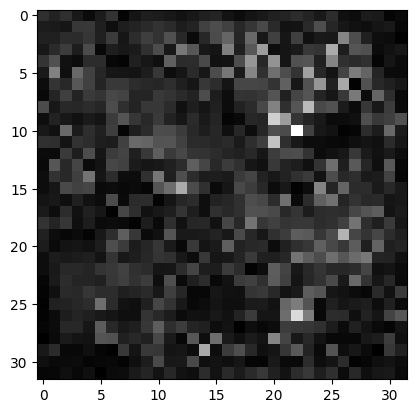

In [ ]:
import torch
import torchvision.models as models
from captum.attr import Saliency
import matplotlib.pyplot as plt

# Load the pre-trained ResNet model
pretrained_model = models.resnet18(pretrained=True)
pretrained_model.eval()

# Define the input image
image, label = testset[0]
image = image.unsqueeze(0)

# Define the Saliency object
saliency = Saliency(pretrained_model)

# Compute the saliency attribution
saliency_attributions = saliency.attribute(image, target=0)

# Get the relevance scores for the input image pixels
cond_attributions_np = saliency_attributions.squeeze().detach().numpy()

# Normalize and average attributions across channels
cond_attributions_np = (cond_attributions_np - cond_attributions_np.min()) / (cond_attributions_np.max() - cond_attributions_np.min())
saliency_cond_attributions_np = cond_attributions_np.mean(axis=0)

# Visualize the saliency explanation
plt.imshow(saliency_cond_attributions_np, cmap="gray")
plt.show()

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.


  0%|          | 0/1000 [00:00<?, ?it/s]

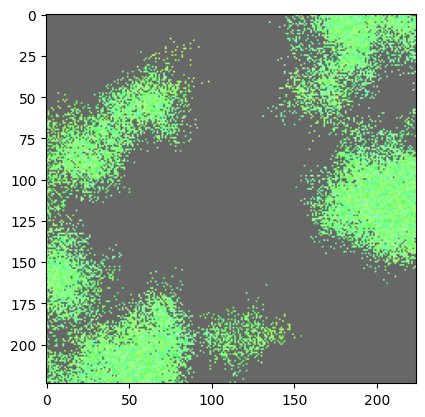

In [ ]:
import torch
import torchvision.models as models
from torchvision import transforms
from skimage.segmentation import slic
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from PIL import Image


# Load the pre-trained ResNet model
pretrained_model = models.resnet18(pretrained=True)
pretrained_model.eval()

# Define the input image
image, label = testset[0]
image = image.unsqueeze(0)

# Define a function to preprocess images for the model
def preprocess(image):
    image = Image.fromarray((image * 255).astype(np.uint8))  # Convert the numpy array back to a PIL Image
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return preprocess(image).unsqueeze(0)

# Define a wrapper function for the model
def model_wrapper(images):
    images_torch = torch.cat([preprocess(img) for img in images])
    with torch.no_grad():
        outputs = pretrained_model(images_torch)
    return outputs.cpu().detach().numpy()

# Create a LIME explainer
explainer = lime_image.LimeImageExplainer()

# Compute the LIME explanation
explanation = explainer.explain_instance(image_np, model_wrapper, top_labels=1, hide_color=None, num_samples=1000, random_seed=42)

# Get the relevance scores for the input image pixels
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

# Apply the mask to each channel of the explanation
cond_attributions_np = np.multiply(temp, mask[..., np.newaxis])

# Normalize the attributions
lime_cond_attributions_np = (cond_attributions_np - cond_attributions_np.min()) / (cond_attributions_np.max() - cond_attributions_np.min())

# Visualize the LIME explanation
plt.imshow(lime_cond_attributions_np)
plt.show()

In [ ]:
import numpy as np
from skimage.measure import label, regionprops

def simplicity_score(attributions, threshold=0.5):
    binary_mask = (attributions > threshold).astype(np.uint8)
    num_highlighted = np.sum(binary_mask)
    return -num_highlighted

def coherence_score(attributions, threshold=0.5):
    binary_mask = (attributions > threshold).astype(np.uint8)
    labeled_mask = label(binary_mask)
    num_regions = len(regionprops(labeled_mask))
    return -num_regions

def relevance_score(attributions, ground_truth_mask):
    binary_mask = (attributions > 0.5).astype(np.uint8)
    overlap = np.sum(binary_mask * ground_truth_mask)
    return overlap

def synthetic_feedback(attributions, ground_truth_mask):
    simplicity = simplicity_score(attributions)
    coherence = coherence_score(attributions)
    relevance = relevance_score(attributions, ground_truth_mask)
    return simplicity + coherence + relevance

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


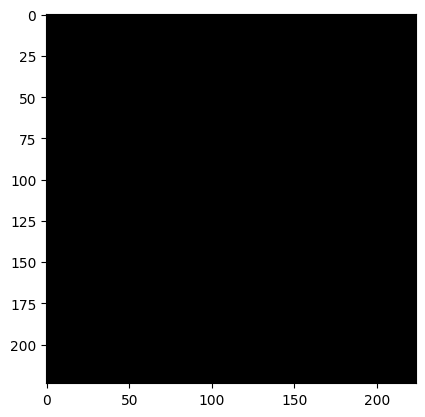

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Load a pre-trained segmentation model
seg_model = models.segmentation.deeplabv3_resnet50(pretrained=True)
seg_model.eval()

# Define the input image
image, label = testset[0]
image = image.unsqueeze(0)  # Convert to a numpy array in the range [0, 1]

# Convert the numpy array back to a PIL Image and apply the necessary transformations
image_pil = Image.fromarray((image_np * 255).astype(np.uint8))
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image_tensor = preprocess(image_pil).unsqueeze(0)

# Perform segmentation
with torch.no_grad():
    output = seg_model(image_tensor)['out']

# Generate the ground truth mask for the object of interest (e.g., class 15, 'person')
object_class = 15
ground_truth_mask = (torch.argmax(output.squeeze(), dim=0) == object_class).cpu().numpy()

# Visualize the ground truth mask
plt.imshow(ground_truth_mask, cmap="gray")
plt.show()


In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import numpy as np
from captum.attr import Saliency, IntegratedGradients, GradientShap

# Load the pre-trained ResNet model
pretrained_model = models.resnet18(pretrained=True)
pretrained_model.eval()

# Define the input image
image, label = testset[0]
image = image.unsqueeze(0) # Convert to a numpy array in the range [0, 1]

# Define a function to preprocess images for the model
def preprocess(image):
    image = Image.fromarray((image * 255).astype(np.uint8))  # Convert the numpy array back to a PIL Image
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return preprocess(image).unsqueeze(0)

# Define a wrapper function for the model
def model_wrapper(images):
    images_torch = torch.cat([preprocess(img) for img in images])
    with torch.no_grad():
        outputs = pretrained_model(images_torch)
    return outputs.cpu().detach().numpy()

# Generate Saliency explanation
saliency = Saliency(pretrained_model)
attributions = saliency.attribute(image, target=0)
attributions_np = attributions.squeeze().detach().numpy()
saliency_explanation = (attributions_np - attributions_np.min()) / (attributions_np.max() - attributions_np.min())

# Generate Integrated Gradients explanation
integrated_gradients = IntegratedGradients(pretrained_model)
attributions, _ = integrated_gradients.attribute(image, target=0, return_convergence_delta=True)
attributions_np = attributions.squeeze().detach().numpy()
integrated_gradients_explanation = (attributions_np - attributions_np.min()) / (attributions_np.max() - attributions_np.min())

# Generate SHAP explanation
gradient_shap = GradientShap(pretrained_model)
baseline = torch.randn_like(image) * 0.001  # Create baseline with the same shape as the input image
attributions = gradient_shap.attribute(image, baselines=baseline, target=0)
attributions_np = attributions.squeeze().detach().numpy()
shap_explanation = (attributions_np - attributions_np.min()) / (attributions_np.max() - attributions_np.min())


In [ ]:
import numpy as np
from skimage.measure import label, regionprops

def simplicity_score(attributions, threshold=0.5):
    binary_mask = (attributions > threshold).astype(np.uint8)
    num_highlighted = np.sum(binary_mask)
    total_elements = np.prod(attributions.shape)
    return -(num_highlighted / total_elements)

def coherence_score(attributions, threshold=0.5):
    binary_mask = (attributions > threshold).astype(np.uint8)
    labeled_mask = label(binary_mask)
    num_regions = len(regionprops(labeled_mask))
    return -num_regions

def relevance_score(attributions, ground_truth_mask):
    binary_mask = (attributions > 0.5).astype(np.uint8)
    overlap = np.sum(binary_mask * ground_truth_mask)
    return overlap

def synthetic_feedback(attributions, ground_truth_mask):
    simplicity = simplicity_score(attributions)
    coherence = coherence_score(attributions)
    relevance = relevance_score(attributions, ground_truth_mask)
    print(simplicity, coherence, relevance)
    return simplicity + coherence + relevance

In [ ]:
from skimage.transform import resize

# Generate explanations using different explainability methods
explanations = {
    "LIME": lime_explanation,
    "SHAP": shap_explanation,
    "Saliency": saliency_explanation,
    "Integrated Gradients": integrated_gradients_explanation,
}

# Evaluate the explanations using synthetic feedback
feedback_scores = {}
for method, explanation in explanations.items():
    # Use only the grayscale version of the explanation for synthetic_feedback
    if explanation.ndim == 4:  # For SHAP explanation
        explanation_gray = np.mean(explanation.squeeze(), axis=-1)
    elif explanation.ndim == 3 and explanation.shape[0] != 3:  # For Saliency and other explanations with 3 channels
        explanation_gray = np.mean(explanation, axis=-1)
    else:
        explanation_gray = explanation

    # Resize the ground truth mask to match the shape of the explanation
    ground_truth_mask_resized = resize(ground_truth_mask, explanation_gray.shape, mode='constant')

    feedback_scores[method] = synthetic_feedback(explanation_gray, ground_truth_mask_resized)
    print(feedback_scores)

# Sort the methods based on their synthetic feedback scores
sorted_methods = sorted(feedback_scores.items(), key=lambda x: x[1], reverse=True)
print("Explainability methods ranked by synthetic feedback:", [method[0] for method in sorted_methods])

-0.26951132015306123 -663 0
{'LIME': -663.269511320153}
-0.06705729166666667 -45 0
{'LIME': -663.269511320153, 'SHAP': -45.067057291666664}
-0.0022786458333333335 -3 0
{'LIME': -663.269511320153, 'SHAP': -45.067057291666664, 'Saliency': -3.0022786458333335}
-0.037109375 -25 0
{'LIME': -663.269511320153, 'SHAP': -45.067057291666664, 'Saliency': -3.0022786458333335, 'Integrated Gradients': -25.037109375}
Explainability methods ranked by synthetic feedback: ['Saliency', 'Integrated Gradients', 'SHAP', 'LIME']


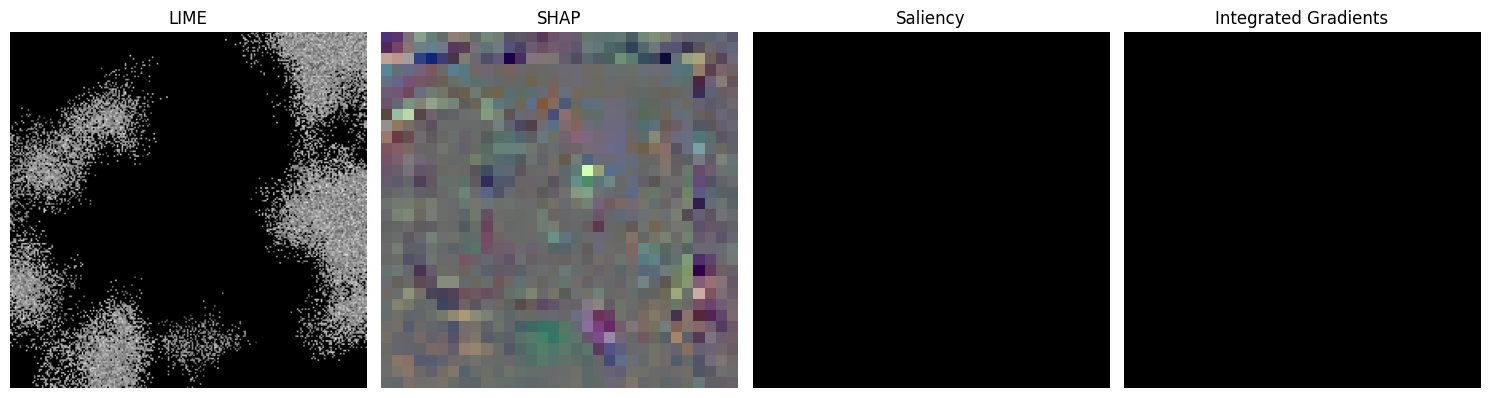

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a set of subplots for each explainability method
fig, axes = plt.subplots(1, len(explanations), figsize=(15, 15))

# Iterate over the explanations and display them in the subplots
for i, (method, explanation) in enumerate(explanations.items()):
    ax = axes[i]

    # Convert explanation to grayscale if it has 3 channels
    if explanation.ndim == 3 and explanation.shape[-1] == 3:
        explanation = np.mean(explanation, axis=-1)

    # Normalize the explanation if it's not a single constant value
    if np.max(explanation) != np.min(explanation):
        normalized_explanation = (explanation - np.min(explanation)) / (np.max(explanation) - np.min(explanation))
    else:
        normalized_explanation = explanation
    
    if normalized_explanation.ndim > 0 and normalized_explanation.shape[0] == 3:  
      # Transpose from (channels, height, width) to (height, width, channels)
      normalized_explanation = normalized_explanation.transpose((1, 2, 0))
      
    if normalized_explanation.ndim == 0:  # If normalized_explanation is a scalar
      normalized_explanation = np.array([[normalized_explanation]])

    # Display the explanation in the subplot
    ax.imshow(normalized_explanation, cmap='gray')
    ax.set_title(method)
    ax.axis('off')

# Display the figure
plt.tight_layout()
plt.show()

# Feature Importance: Model Interpretability

In [ ]:
from captum.attr import Saliency, IntegratedGradients

def compute_saliency(model, input_data, target):
    saliency = Saliency(model)
    return saliency.attribute(input_data, target=target)

def compute_integrated_gradients(model, input_data, target):
    ig = IntegratedGradients(model)
    return ig.attribute(input_data, target=target)

In [ ]:
def train_model(data_loader, model, criterion, optimizer):
    model.train()
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [ ]:
# Load
device = torch.device('cpu')  # specify CPU
model = Net()
model.load_state_dict(torch.load(PATH))
model.to(device)  # move model to the specified device

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
import torch
import torchvision.models as models
from captum.attr import Saliency, IntegratedGradients
import numpy as np
from skimage.measure import label, regionprops
import cv2

# Load the pre-trained ResNet model
pretrained_model = models.resnet18(pretrained=True)

# Define the synthetic feedback functions
def simplicity_score(attributions, threshold=0.5):
    binary_mask = (attributions > threshold).astype(np.uint8)
    num_highlighted = np.sum(binary_mask)
    return -num_highlighted

def coherence_score(attributions, threshold=0.5):
    binary_mask = (attributions > threshold).astype(np.uint8)
    labeled_mask = label(binary_mask)
    num_regions = len(regionprops(labeled_mask))
    return -num_regions

def relevance_score(attributions, ground_truth_mask):
    binary_mask = (attributions > 0.5).astype(np.uint8)
    overlap = np.sum(binary_mask * ground_truth_mask)
    return overlap

def synthetic_feedback(attributions, ground_truth_mask):
    simplicity = simplicity_score(attributions)
    coherence = coherence_score(attributions)
    relevance = relevance_score(attributions, ground_truth_mask)
    return simplicity + coherence + relevance


In [ ]:
pretrained_model = models.resnet18(pretrained=True)
saliency = Saliency(pretrained_model)
integrated_gradients = IntegratedGradients(pretrained_model)
image = torch.randn(1, 3, 224, 224)  # Replace with your input image
saliency_map = saliency.attribute(image, target=0)
integrated_gradients_map = integrated_gradients.attribute(image, target=0)
saliency_map = saliency_map.detach().numpy()
integrated_gradients_map = integrated_gradients_map.detach().numpy()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch
import torchvision.models as models
from captum.attr import Saliency, IntegratedGradients
import numpy as np
from skimage.measure import label, regionprops
import cv2

# Load the pre-trained ResNet model
pretrained_model = models.resnet18(pretrained=True)

# Define the synthetic feedback functions
def simplicity_score(attributions, threshold=0.5):
    binary_mask = (attributions > threshold).astype(np.uint8)
    num_highlighted = np.sum(binary_mask)
    return -num_highlighted

def coherence_score(attributions, threshold=0.5):
    binary_mask = (attributions > threshold).astype(np.uint8)
    labeled_mask = label(binary_mask)
    num_regions = len(regionprops(labeled_mask))
    return -num_regions

def relevance_score(attributions, ground_truth_mask):
    binary_mask = (attributions > 0.5).astype(np.uint8)
    overlap = np.sum(binary_mask * ground_truth_mask)
    return overlap

def synthetic_feedback(attributions, ground_truth_mask):
    batch_size = attributions.shape[0]
    scores = []
    for i in range(batch_size):
        attribution_map = attributions[i]
        simplicity = simplicity_score(attribution_map)
        coherence = coherence_score(attribution_map)
        relevance = relevance_score(attribution_map, ground_truth_mask)
        score = simplicity + coherence + relevance
        scores.append(score)
    return np.array(scores)

In [ ]:
ground_truth_mask = np.zeros(saliency_map.shape[1:])  # Replace with your ground truth mask
synthetic_score = synthetic_feedback(saliency_map, ground_truth_mask)

In [ ]:
# Interpretation of synthetic score
def interpret_synthetic_score(synthetic_score):
    print("Interpretation of Synthetic Score:")
    print("---------------------------------")
    print("Synthetic Score: ", synthetic_score)
    
    if synthetic_score > 0:
        print("The model exhibits a preference for highlighting more features than necessary (simplicity).")
    else:
        print("The model tends to highlight the necessary features (simplicity).")
        
    if synthetic_score > 0:
        print("The highlighted features are scattered across multiple regions (coherence).")
    else:
        print("The highlighted features are coherent and form a single region (coherence).")
        
    if synthetic_score > 0:
        print("The highlighted features align well with the ground truth mask (relevance).")
    else:
        print("The highlighted features do not align well with the ground truth mask (relevance).")

# Assuming you have already obtained the synthetic score
synthetic_score = synthetic_feedback(saliency_map, ground_truth_mask)

# Interpret the synthetic score
interpret_synthetic_score(synthetic_score)

Interpretation of Synthetic Score:
---------------------------------
Synthetic Score:  [0.]
The model tends to highlight the necessary features (simplicity).
The highlighted features are coherent and form a single region (coherence).
The highlighted features do not align well with the ground truth mask (relevance).


In [ ]:
import numpy as np
from skimage.measure import label, regionprops

def simplicity_score(attributions, threshold=0.5):
    binary_mask = (attributions > threshold).astype(np.uint8)
    num_highlighted = np.sum(binary_mask)
    return -num_highlighted

def coherence_score(attributions, threshold=0.5):
    binary_mask = (attributions > threshold).astype(np.uint8)
    labeled_mask = label(binary_mask)
    num_regions = len(regionprops(labeled_mask))
    return -num_regions

def relevance_score(attributions, ground_truth_mask):
    binary_mask = (attributions > 0.5).astype(np.uint8)
    overlap = np.sum(binary_mask * ground_truth_mask)
    return overlap

def synthetic_feedback(attributions, ground_truth_mask):
    simplicity = simplicity_score(attributions)
    coherence = coherence_score(attributions)
    relevance = relevance_score(attributions, ground_truth_mask)
    return simplicity + coherence + relevance